## Question 1 

#### Part 1


In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv,pinv
from numpy.linalg import det
from numpy.linalg import norm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import empirical_covariance as ecov
from mpl_toolkits import mplot3d
from sklearn.datasets import make_spd_matrix # crating positive semidefinite matrix
from numpy import linalg as LA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
np.random.seed(123)
plt.rcParams["figure.figsize"] = 12.8, 9.6
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

In [0]:
def Sample_Generator(p_w1,p_w2,p_w3,p_w4,count):
  N = np.random.uniform( size=count)
  n1=N[N<=p_w1]
  n2=N[(N>p_w1) & (N<=(p_w1+p_w2))]
  n3=N[(N>(p_w1+p_w2)) & (N<=(p_w1+p_w2+p_w3))]
  n4=N[(N>(p_w1+p_w2+p_w3))]
  return(len(n1),len(n2),len(n3),len(n4))

In [0]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [0]:
def multi_var_gen(size):
  p_w1=0.2
  p_w2=0.25
  p_w3=0.15
  p_w4=0.4
  n1,n2,n3,n4 = Sample_Generator(p_w1,p_w2,p_w3,p_w4,size)
  mean1=[-3,-3,-3]
  mean2=[1,1,1]
  mean3=[-1,1,-1]
  mean4=[6,-1,3]
  cov1=make_spd_matrix(3,random_state=11)
  cov2=make_spd_matrix(3,random_state=123)
  cov3=make_spd_matrix(3,random_state=51)
  cov4=make_spd_matrix(3,random_state=51)
  o1 = np.random.multivariate_normal(mean1, cov1, (n1))
  o2 = np.random.multivariate_normal(mean2, cov2, (n2))
  o3 = np.random.multivariate_normal(mean3, cov3, (n3))
  o4 = np.random.multivariate_normal(mean4, cov4, (n4))

  return(n1,n2,n3,n4,o1,o2,o3,o4,mean1,mean2,mean3,mean4,cov1,cov2,cov3,cov4,p_w1,p_w2,p_w3,p_w4)


In [0]:
n1,n2,n3,n4,o1,o2,o3,o4,mean1,mean2,mean3,mean4,cov1,cov2,cov3,cov4,p_w1,p_w2,p_w3,p_w4=multi_var_gen(1000)

Text(0.5, 0.92, 'Data points_projection')

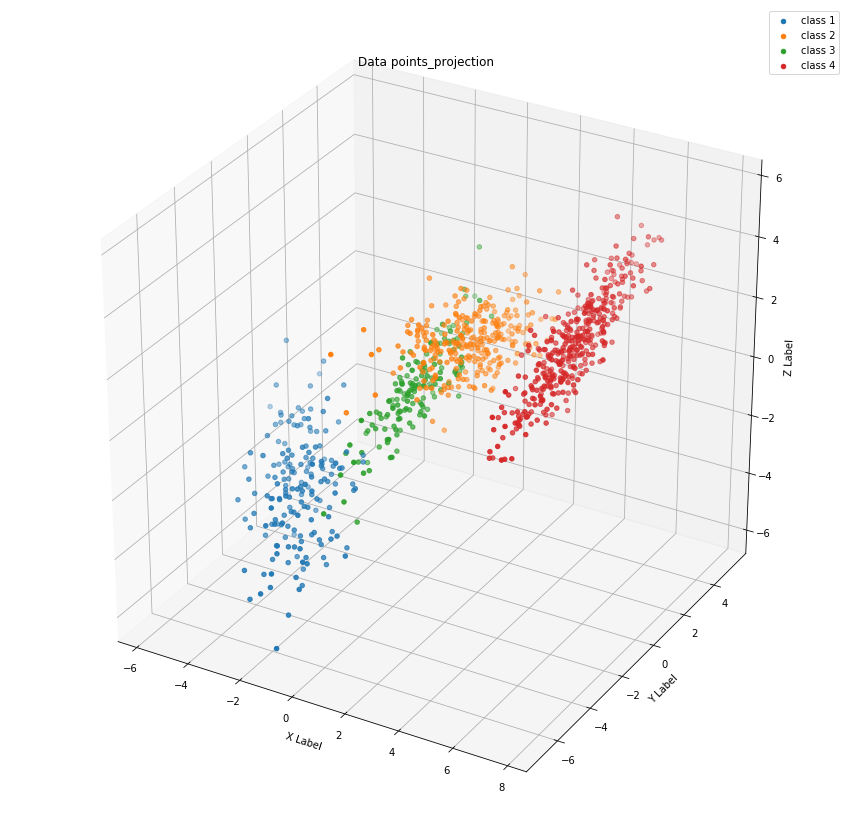

In [0]:
fig1=plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(o1[:,0],o1[:,1],o1[:,2],Label="class 1")
ax.scatter(o2[:,0],o2[:,1],o2[:,2],Label="class 2")
ax.scatter(o3[:,0],o3[:,1],o3[:,2],Label="class 3")
ax.scatter(o4[:,0],o4[:,1],o4[:,2],Label="class 4")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()
ax.set_title("Data points_projection for 1000 points")


#### Part 2

In [0]:
mean1=np.array(mean1).reshape(3,1)
mean2=np.array(mean2).reshape(3,1)
mean3=np.array(mean3).reshape(3,1)
mean4=np.array(mean4).reshape(3,1)
o1=o1.reshape(3,-1)
o2=o2.reshape(3,-1)
o3=o3.reshape(3,-1)
o4=o4.reshape(3,-1)

In [0]:
mean2,cov2

(array([[1],
        [1],
        [1]]), array([[ 0.40956006,  0.35634719, -0.0770371 ],
        [ 0.35634719,  3.32987452, -0.58506238],
        [-0.0770371 , -0.58506238,  0.72491066]]))

In [0]:
W1=(-0.5)*inv(cov1) # calculating the various generator functions to classify them into the various classes
W2=(-0.5)*inv(cov2)
W3=(-0.5)*inv(cov3)
W4=(-0.5)*inv(cov4)

w1=inv(cov1)@mean1
w2=inv(cov2)@mean2
w3=inv(cov3)@mean3
w4=inv(cov4)@mean4

w10=-(mean1.T@inv(cov1)@mean1/2)- np.log(det(cov1))/2 + np.log(p_w1)
w20=-(mean2.T@inv(cov2)@mean2/2)- np.log(det(cov2))/2 + np.log(p_w2)
w30=-(mean3.T@inv(cov3)@mean3/2)- np.log(det(cov3))/2 + np.log(p_w3)
w40=-(mean4.T@inv(cov4)@mean4/2)- np.log(det(cov4))/2 + np.log(p_w4)

g1_1=np.diag(o1.T@W1@o1) + (w1.T@o1) + w10
g1_2=np.diag(o1.T@W2@o1) + (w2.T@o1) + w20
g1_3=np.diag(o1.T@W3@o1) + (w3.T@o1) + w30
g1_4=np.diag(o1.T@W4@o1) + (w4.T@o1) + w40


g2_1=np.diag(o2.T@W1@o2) + (w1.T@o2) + w10
g2_2=np.diag(o2.T@W2@o2) + (w2.T@o2) + w20
g2_3=np.diag(o2.T@W3@o2) + (w3.T@o2) + w30
g2_4=np.diag(o2.T@W4@o2) + (w4.T@o2) + w40

g3_1=np.diag(o3.T@W1@o3) + (w1.T@o3) + w10
g3_2=np.diag(o3.T@W2@o3) + (w2.T@o3) + w20
g3_3=np.diag(o3.T@W3@o3) + (w3.T@o3) + w30
g3_4=np.diag(o3.T@W4@o3) + (w4.T@o3) + w40

g4_1=np.diag(o4.T@W1@o4) + (w1.T@o4) + w10
g4_2=np.diag(o4.T@W2@o4) + (w2.T@o4) + w20
g4_3=np.diag(o4.T@W3@o4) + (w3.T@o4) + w30
g4_4=np.diag(o4.T@W4@o4) + (w4.T@o4) + w30


ww1=pd.DataFrame(data=o1.T,columns=['d1','d2','d3'])
ww1['Real_Label']=np.ones(n1)*1

ww2=pd.DataFrame(data=o2.T,columns=['d1','d2','d3'])
ww2['Real_Label']=np.ones(n2)*2

ww3=pd.DataFrame(data=o3.T,columns=['d1','d2','d3'])
ww3['Real_Label']=np.ones(n3)*3

ww4=pd.DataFrame(data=o4.T,columns=['d1','d2','d3'])
ww4['Real_Label']=np.ones(n4)*4

n1_1=ww1[((g1_1>g1_2)&(g1_1>g1_3)&(g1_1>g1_4)).reshape(-1,1)]
n1_2=ww1[((g1_2>g1_1)&(g1_2>g1_3)&(g1_2>g1_4)).reshape(-1,1)]
n1_3=ww1[((g1_3>g1_1)&(g1_3>g1_2)&(g1_3>g1_4)).reshape(-1,1)]
n1_4=ww1[((g1_4>g1_1)&(g1_4>g1_2)&(g1_4>g1_3)).reshape(-1,1)]

n2_1=ww2[((g2_1>g2_2)&(g2_1>g2_3)&(g2_1>g2_4)).reshape(-1,1)]
n2_2=ww2[((g2_2>g2_1)&(g2_2>g2_3)&(g2_2>g2_4)).reshape(-1,1)]
n2_3=ww2[((g2_3>g2_1)&(g2_3>g2_2)&(g2_3>g2_4)).reshape(-1,1)]
n2_4=ww2[((g2_4>g2_1)&(g2_4>g2_2)&(g2_4>g2_3)).reshape(-1,1)]

n3_1=ww3[((g3_1>g3_2)&(g3_1>g3_3)&(g3_1>g3_4)).reshape(-1,1)]
n3_2=ww3[((g3_2>g3_1)&(g3_2>g3_3)&(g3_2>g3_4)).reshape(-1,1)]
n3_3=ww3[((g3_3>g3_1)&(g3_3>g3_2)&(g3_3>g3_4)).reshape(-1,1)]
n3_4=ww3[((g3_4>g3_1)&(g3_4>g3_2)&(g3_4>g3_3)).reshape(-1,1)]

n4_1=ww4[((g4_1>g4_2)&(g4_1>g4_3)&(g4_1>g4_4)).reshape(-1,1)]
n4_2=ww4[((g4_2>g4_1)&(g4_2>g4_3)&(g4_2>g4_4)).reshape(-1,1)]
n4_3=ww4[((g4_3>g4_1)&(g4_3>g4_2)&(g4_3>g4_4)).reshape(-1,1)]
n4_4=ww4[((g4_4>g4_1)&(g4_4>g4_2)&(g4_4>g4_3)).reshape(-1,1)]




In [0]:
d=list([len(n1_1),len(n1_2),len(n1_3),len(n1_4),len(n2_1),len(n2_2),len(n2_3),len(n2_4),len(n3_1),len(n3_2),len(n3_3),len(n3_4),len(n4_1),len(n4_2),len(n4_3),len(n4_4)])
d=np.array(d).reshape(4,4)

confu=pd.DataFrame(data=d,columns=['Predicted Label 1','Predicted Label 2','Predicted Label 3','Predicted Label 4'],index=['Real Label 1','Real Label 2','Real Label 3','Real Label 4'])

In [0]:
confu

,Predicted Label 1,Predicted Label 2,Predicted Label 3,Predicted Label 4
Real Label 1,165,1,12,0
Real Label 2,2,261,12,4
Real Label 3,12,75,66,1
Real Label 4,15,11,79,284


In [0]:
print("Sample size for class 1 is {} sample size for class 2 is {} Sample size of class 3 is {} Sample size of class 4 is {}".format(n1,n2,n3,n4))
print('The number of labels in class 1 classified as label 1 are {} , as label 2 are {} , as label 3 are {} and as label 4 are {}'.format(len(n1_1),len(n1_2),len(n1_3),len(n1_4))) 
print('The number of labels in class 2 classified as label 1 are {} , as label 2 are {} , as label 3 are {} and as label 4 are {}'.format(len(n2_1),len(n2_2),len(n2_3),len(n2_4))) 
print('The number of labels in class 3 classified as label 1 are {} , as label 2 are {} , as label 3 are {} and as label 4 are {}'.format(len(n3_1),len(n3_2),len(n3_3),len(n3_4))) 
print('The number of labels in class 4 classified as label 1 are {} , as label 2 are {} , as label 3 are {} and as label 4 are {}'.format(len(n4_1),len(n4_2),len(n4_3),len(n4_4))) 

error=(len(n1_2)+len(n1_3)+len(n1_4)+len(n2_1)+len(n2_3)+len(n2_4)+len(n3_1)+len(n3_2)+len(n3_4)+len(n4_1)+len(n4_2)+len(n4_3))

print("Total Error {}".format(error))
print("Total estimated probability of  Error is {}".format(error/1000))


Sample size for class 1 is 178 sample size for class 2 is 279 Sample size of class 3 is 154 Sample size of class 4 is 389
The number of labels in class 1 classified as label 1 are 165 , as label 2 are 1 , as label 3 are 12 and as label 4 are 0
The number of labels in class 2 classified as label 1 are 2 , as label 2 are 261 , as label 3 are 12 and as label 4 are 4
The number of labels in class 3 classified as label 1 are 12 , as label 2 are 75 , as label 3 are 66 and as label 4 are 1
The number of labels in class 4 classified as label 1 are 15 , as label 2 are 11 , as label 3 are 79 and as label 4 are 284
Total Error 224
Total estimated probability of  Error is 0.224


Text(0.5, 0.92, 'Data points_projection')

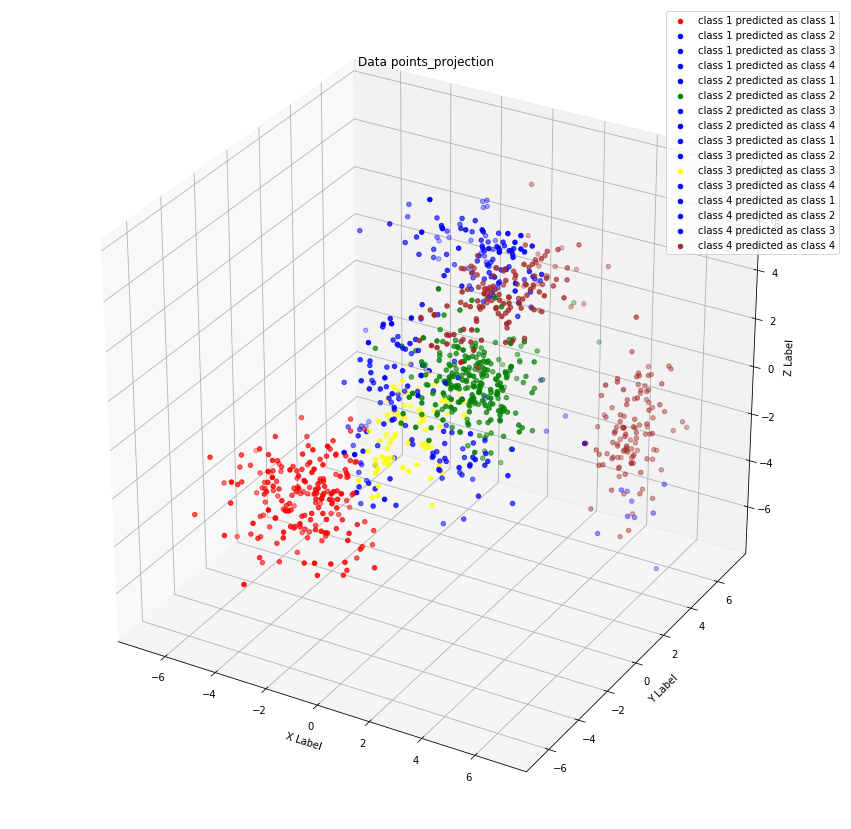

In [0]:
fig1=plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(n1_1['d1'],n1_1['d2'],n1_1['d3'],Label="class 1 predicted as class 1",c='red')
ax.scatter(n1_2['d1'],n1_2['d2'],n1_2['d3'],Label="class 1 predicted as class 2",c='blue')
ax.scatter(n1_3['d1'],n1_3['d2'],n1_3['d3'],Label="class 1 predicted as class 3",c='blue')
ax.scatter(n1_4['d1'],n1_4['d2'],n1_4['d3'],Label="class 1 predicted as class 4",c='blue')

ax.scatter(n2_1['d1'],n2_1['d2'],n2_1['d3'],Label="class 2 predicted as class 1",c='blue')
ax.scatter(n2_2['d1'],n2_2['d2'],n2_2['d3'],Label="class 2 predicted as class 2",c='green')
ax.scatter(n2_3['d1'],n2_3['d2'],n2_3['d3'],Label="class 2 predicted as class 3",c='blue')
ax.scatter(n2_4['d1'],n2_4['d2'],n2_4['d3'],Label="class 2 predicted as class 4",c='blue')

ax.scatter(n3_1['d1'],n3_1['d2'],n3_1['d3'],Label="class 3 predicted as class 1",c='blue')
ax.scatter(n3_2['d1'],n3_2['d2'],n3_2['d3'],Label="class 3 predicted as class 2",c='blue')
ax.scatter(n3_3['d1'],n3_3['d2'],n3_3['d3'],Label="class 3 predicted as class 3",c='yellow')
ax.scatter(n3_4['d1'],n3_4['d2'],n3_4['d3'],Label="class 3 predicted as class 4",c='blue')

ax.scatter(n4_1['d1'],n4_1['d2'],n4_1['d3'],Label="class 4 predicted as class 1",c='blue')
ax.scatter(n4_2['d1'],n4_2['d2'],n4_2['d3'],Label="class 4 predicted as class 2",c='blue')
ax.scatter(n4_3['d1'],n4_3['d2'],n4_3['d3'],Label="class 4 predicted as class 3",c='blue')
ax.scatter(n4_4['d1'],n4_4['d2'],n4_4['d3'],Label="class 4 predicted as class 4",c='brown')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()
ax.set_title("Data points_projection")


So far we have created a distribution that has a theoretical MAP classification error of around 22.4 percentage.
from the same distribution we now have to sample 10000 examples and classify them using MAP

### Generating Test set

In [0]:
n1,n2,n3,n4,o1,o2,o3,o4,mean1,mean2,mean3,mean4,cov1,cov2,cov3,cov4,p_w1,p_w2,p_w3,p_w4=multi_var_gen(10000)

Text(0.5, 0.92, 'Data points_projection for 10000 test points')

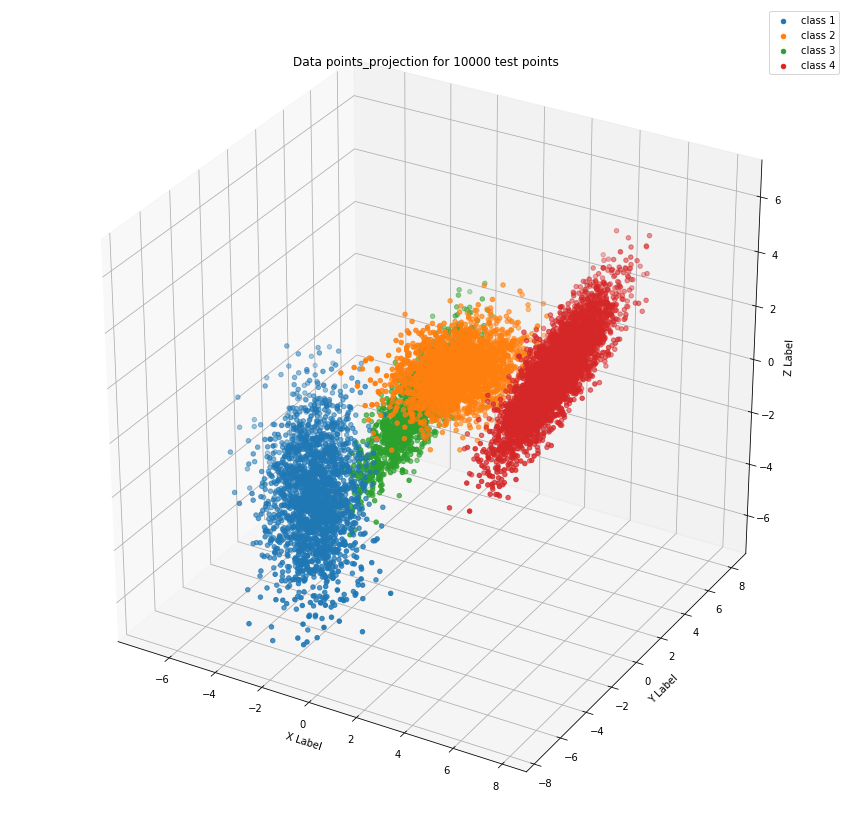

In [0]:
fig1=plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(o1[:,0],o1[:,1],o1[:,2],Label="class 1")
ax.scatter(o2[:,0],o2[:,1],o2[:,2],Label="class 2")
ax.scatter(o3[:,0],o3[:,1],o3[:,2],Label="class 3")
ax.scatter(o4[:,0],o4[:,1],o4[:,2],Label="class 4")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()
ax.set_title("Data points_projection for 10000 test points")


In [0]:
mean1=np.array(mean1).reshape(3,1)
mean2=np.array(mean2).reshape(3,1)
mean3=np.array(mean3).reshape(3,1)
mean4=np.array(mean4).reshape(3,1)
o1=o1.reshape(3,-1)
o2=o2.reshape(3,-1)
o3=o3.reshape(3,-1)
o4=o4.reshape(3,-1)

In [0]:
W1=(-0.5)*inv(cov1) # calculating the various generator functions to classify them into the various classes
W2=(-0.5)*inv(cov2)
W3=(-0.5)*inv(cov3)
W4=(-0.5)*inv(cov4)

w1=inv(cov1)@mean1
w2=inv(cov2)@mean2
w3=inv(cov3)@mean3
w4=inv(cov4)@mean4

w10=-(mean1.T@inv(cov1)@mean1/2)- np.log(det(cov1))/2 + np.log(p_w1)
w20=-(mean2.T@inv(cov2)@mean2/2)- np.log(det(cov2))/2 + np.log(p_w2)
w30=-(mean3.T@inv(cov3)@mean3/2)- np.log(det(cov3))/2 + np.log(p_w3)
w40=-(mean4.T@inv(cov4)@mean4/2)- np.log(det(cov4))/2 + np.log(p_w4)

g1_1=np.diag(o1.T@W1@o1) + (w1.T@o1) + w10
g1_2=np.diag(o1.T@W2@o1) + (w2.T@o1) + w20
g1_3=np.diag(o1.T@W3@o1) + (w3.T@o1) + w30
g1_4=np.diag(o1.T@W4@o1) + (w4.T@o1) + w40


g2_1=np.diag(o2.T@W1@o2) + (w1.T@o2) + w10
g2_2=np.diag(o2.T@W2@o2) + (w2.T@o2) + w20
g2_3=np.diag(o2.T@W3@o2) + (w3.T@o2) + w30
g2_4=np.diag(o2.T@W4@o2) + (w4.T@o2) + w40

g3_1=np.diag(o3.T@W1@o3) + (w1.T@o3) + w10
g3_2=np.diag(o3.T@W2@o3) + (w2.T@o3) + w20
g3_3=np.diag(o3.T@W3@o3) + (w3.T@o3) + w30
g3_4=np.diag(o3.T@W4@o3) + (w4.T@o3) + w40

g4_1=np.diag(o4.T@W1@o4) + (w1.T@o4) + w10
g4_2=np.diag(o4.T@W2@o4) + (w2.T@o4) + w20
g4_3=np.diag(o4.T@W3@o4) + (w3.T@o4) + w30
g4_4=np.diag(o4.T@W4@o4) + (w4.T@o4) + w30


ww1=pd.DataFrame(data=o1.T,columns=['d1','d2','d3'])
ww1['Real_Label']=np.ones(n1)*1

ww2=pd.DataFrame(data=o2.T,columns=['d1','d2','d3'])
ww2['Real_Label']=np.ones(n2)*2

ww3=pd.DataFrame(data=o3.T,columns=['d1','d2','d3'])
ww3['Real_Label']=np.ones(n3)*3

ww4=pd.DataFrame(data=o4.T,columns=['d1','d2','d3'])
ww4['Real_Label']=np.ones(n4)*4

n1_1=ww1[((g1_1>g1_2)&(g1_1>g1_3)&(g1_1>g1_4)).reshape(-1,1)]
n1_2=ww1[((g1_2>g1_1)&(g1_2>g1_3)&(g1_2>g1_4)).reshape(-1,1)]
n1_3=ww1[((g1_3>g1_1)&(g1_3>g1_2)&(g1_3>g1_4)).reshape(-1,1)]
n1_4=ww1[((g1_4>g1_1)&(g1_4>g1_2)&(g1_4>g1_3)).reshape(-1,1)]

n2_1=ww2[((g2_1>g2_2)&(g2_1>g2_3)&(g2_1>g2_4)).reshape(-1,1)]
n2_2=ww2[((g2_2>g2_1)&(g2_2>g2_3)&(g2_2>g2_4)).reshape(-1,1)]
n2_3=ww2[((g2_3>g2_1)&(g2_3>g2_2)&(g2_3>g2_4)).reshape(-1,1)]
n2_4=ww2[((g2_4>g2_1)&(g2_4>g2_2)&(g2_4>g2_3)).reshape(-1,1)]

n3_1=ww3[((g3_1>g3_2)&(g3_1>g3_3)&(g3_1>g3_4)).reshape(-1,1)]
n3_2=ww3[((g3_2>g3_1)&(g3_2>g3_3)&(g3_2>g3_4)).reshape(-1,1)]
n3_3=ww3[((g3_3>g3_1)&(g3_3>g3_2)&(g3_3>g3_4)).reshape(-1,1)]
n3_4=ww3[((g3_4>g3_1)&(g3_4>g3_2)&(g3_4>g3_3)).reshape(-1,1)]

n4_1=ww4[((g4_1>g4_2)&(g4_1>g4_3)&(g4_1>g4_4)).reshape(-1,1)]
n4_2=ww4[((g4_2>g4_1)&(g4_2>g4_3)&(g4_2>g4_4)).reshape(-1,1)]
n4_3=ww4[((g4_3>g4_1)&(g4_3>g4_2)&(g4_3>g4_4)).reshape(-1,1)]
n4_4=ww4[((g4_4>g4_1)&(g4_4>g4_2)&(g4_4>g4_3)).reshape(-1,1)]




In [0]:
d=list([len(n1_1),len(n1_2),len(n1_3),len(n1_4),len(n2_1),len(n2_2),len(n2_3),len(n2_4),len(n3_1),len(n3_2),len(n3_3),len(n3_4),len(n4_1),len(n4_2),len(n4_3),len(n4_4)])
d=np.array(d).reshape(4,4)

confu=pd.DataFrame(data=d,columns=['Predicted Label 1','Predicted Label 2','Predicted Label 3','Predicted Label 4'],index=['Real Label 1','Real Label 2','Real Label 3','Real Label 4'])

In [0]:
print("Sample size for class 1 is {} sample size for class 2 is {} Sample size of class 3 is {} Sample size of class 4 is {}".format(n1,n2,n3,n4))
print('The number of labels in class 1 classified as label 1 are {} , as label 2 are {} , as label 3 are {} and as label 4 are {}'.format(len(n1_1),len(n1_2),len(n1_3),len(n1_4))) 
print('The number of labels in class 2 classified as label 1 are {} , as label 2 are {} , as label 3 are {} and as label 4 are {}'.format(len(n2_1),len(n2_2),len(n2_3),len(n2_4))) 
print('The number of labels in class 3 classified as label 1 are {} , as label 2 are {} , as label 3 are {} and as label 4 are {}'.format(len(n3_1),len(n3_2),len(n3_3),len(n3_4))) 
print('The number of labels in class 4 classified as label 1 are {} , as label 2 are {} , as label 3 are {} and as label 4 are {}'.format(len(n4_1),len(n4_2),len(n4_3),len(n4_4))) 

error=(len(n1_2)+len(n1_3)+len(n1_4)+len(n2_1)+len(n2_3)+len(n2_4)+len(n3_1)+len(n3_2)+len(n3_4)+len(n4_1)+len(n4_2)+len(n4_3))

print("Total Error {}".format(error))
print("Total estimated probability of  Error is {}".format(error/10000))


Sample size for class 1 is 2042 sample size for class 2 is 2417 Sample size of class 3 is 1515 Sample size of class 4 is 4026
The number of labels in class 1 classified as label 1 are 1886 , as label 2 are 10 , as label 3 are 146 and as label 4 are 0
The number of labels in class 2 classified as label 1 are 31 , as label 2 are 2177 , as label 3 are 179 and as label 4 are 30
The number of labels in class 3 classified as label 1 are 142 , as label 2 are 507 , as label 3 are 843 and as label 4 are 23
The number of labels in class 4 classified as label 1 are 399 , as label 2 are 194 , as label 3 are 434 and as label 4 are 2999
Total Error 2095
Total estimated probability of  Error is 0.2095


In [0]:
confu

,Predicted Label 1,Predicted Label 2,Predicted Label 3,Predicted Label 4
Real Label 1,1886,10,146,0
Real Label 2,31,2177,179,30
Real Label 3,142,507,843,23
Real Label 4,399,194,434,2999


Text(0.5, 0.92, 'Data points_projection')

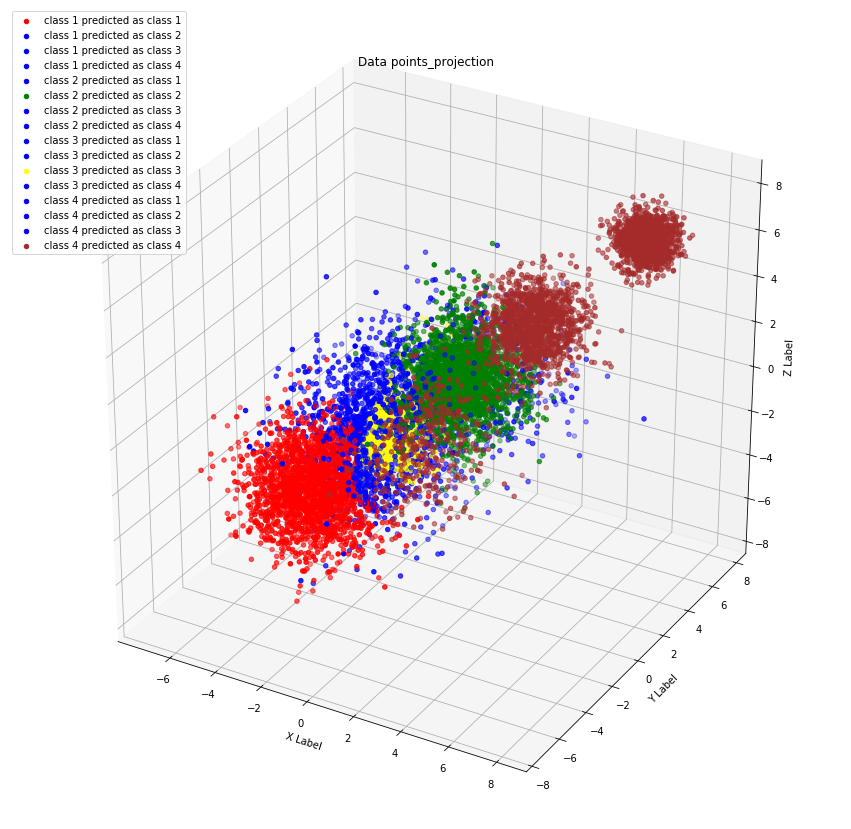

In [0]:
fig1=plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(n1_1['d1'],n1_1['d2'],n1_1['d3'],Label="class 1 predicted as class 1",c='red')
ax.scatter(n1_2['d1'],n1_2['d2'],n1_2['d3'],Label="class 1 predicted as class 2",c='blue')
ax.scatter(n1_3['d1'],n1_3['d2'],n1_3['d3'],Label="class 1 predicted as class 3",c='blue')
ax.scatter(n1_4['d1'],n1_4['d2'],n1_4['d3'],Label="class 1 predicted as class 4",c='blue')

ax.scatter(n2_1['d1'],n2_1['d2'],n2_1['d3'],Label="class 2 predicted as class 1",c='blue')
ax.scatter(n2_2['d1'],n2_2['d2'],n2_2['d3'],Label="class 2 predicted as class 2",c='green')
ax.scatter(n2_3['d1'],n2_3['d2'],n2_3['d3'],Label="class 2 predicted as class 3",c='blue')
ax.scatter(n2_4['d1'],n2_4['d2'],n2_4['d3'],Label="class 2 predicted as class 4",c='blue')

ax.scatter(n3_1['d1'],n3_1['d2'],n3_1['d3'],Label="class 3 predicted as class 1",c='blue')
ax.scatter(n3_2['d1'],n3_2['d2'],n3_2['d3'],Label="class 3 predicted as class 2",c='blue')
ax.scatter(n3_3['d1'],n3_3['d2'],n3_3['d3'],Label="class 3 predicted as class 3",c='yellow')
ax.scatter(n3_4['d1'],n3_4['d2'],n3_4['d3'],Label="class 3 predicted as class 4",c='blue')

ax.scatter(n4_1['d1'],n4_1['d2'],n4_1['d3'],Label="class 4 predicted as class 1",c='blue')
ax.scatter(n4_2['d1'],n4_2['d2'],n4_2['d3'],Label="class 4 predicted as class 2",c='blue')
ax.scatter(n4_3['d1'],n4_3['d2'],n4_3['d3'],Label="class 4 predicted as class 3",c='blue')
ax.scatter(n4_4['d1'],n4_4['d2'],n4_4['d3'],Label="class 4 predicted as class 4",c='brown')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()
ax.set_title("Data points_projection")


#### Part 3 - method 1

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras

In [0]:
def get_data(points):
  n1,n2,n3,n4,o1,o2,o3,o4,mean1,mean2,mean3,mean4,cov1,cov2,cov3,cov4,p_w1,p_w2,p_w3,p_w4=multi_var_gen(points)
  X=np.vstack((o1,o2,o3,o4))
  Y=np.hstack([np.ones(n1)*1,np.ones(n2)*2,np.ones(n3)*3,np.ones(n4)*4])
  y=to_categorical(Y)[:,1:]
  Y=np.array([t-1 for t in Y])

  return(X,y,Y)

In [0]:
def acuuracy_plot(count,i,mean):
  plt.plot(range(len(i)),mean)
  plt.xticks(range(len(i)),i)
  plt.ylabel("Accuracy")
  plt.xlabel("Number of units/nodes")
  plt.title("Dataset of size {} (Accuracy vs No. of units ".format(count))

In [0]:
def classifier(i):
  keras.backend.clear_session()
  model=Sequential()
  model.add(Dense(i, input_dim=3, activation='softplus'))
  model.add(Dense(4, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
  return(model)

In [0]:
# model to run the whole dataset
def classifier_complete(i,X,y,c):
  keras.backend.clear_session()
  model=Sequential()
  model.add(Dense(i, input_dim=3, activation='softplus'))
  model.add(Dense(4, activation='softmax'))
  model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 
  model.fit(X,y,epochs=1000,batch_size=c)
  
  
  return(model)

In [0]:
test_x=np.vstack((o1.T,o2.T,o3.T,o4.T))
test_y=np.hstack([np.ones(len(o1.T))*1,np.ones(len(o2.T))*2,np.ones(len(o3.T))*3,np.ones(len(o4.T))*4])
test_y=np.array([t-1 for t in test_y])

#### 100 data points training set

In [0]:
X,y,Y=get_data(100)
estimator = KerasClassifier(build_fn=classifier, epochs=10, batch_size=4, verbose=0)
i=[4,10,15,20,25,40,45]
param_grid = dict(i=i)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=10,n_jobs=-1)
result = grid.fit(X, y)


Best accuracy: 0.680000 using nodes= {'i': 40}


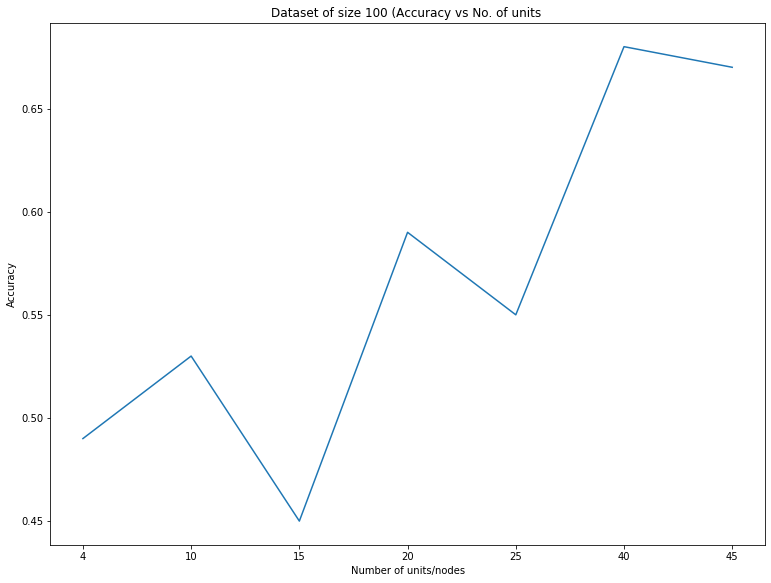

In [0]:
print("Best accuracy: %f using nodes= %s" % (result.best_score_, result.best_params_))
mean=result.cv_results_['mean_test_score']
acuuracy_plot(100,i,mean)

In [0]:
X.shape,y.shape,test_x.shape,test_y.shape

((100, 3), (100, 4), (10000, 3), (10000,))

In [0]:
final=classifier_complete(result.best_params_['i'],X,y,100)


Epoch 1/150
100/100 [==============================] - 0s 1ms/step - loss: 2.6849 - acc: 0.2000
Epoch 2/150
100/100 [==============================] - 0s 56us/step - loss: 2.3572 - acc: 0.2000
Epoch 3/150
100/100 [==============================] - 0s 63us/step - loss: 2.0701 - acc: 0.2000
Epoch 4/150
100/100 [==============================] - 0s 56us/step - loss: 1.8273 - acc: 0.2000
Epoch 5/150
100/100 [==============================] - 0s 26us/step - loss: 1.6298 - acc: 0.2000
Epoch 6/150
100/100 [==============================] - 0s 29us/step - loss: 1.4742 - acc: 0.2500
Epoch 7/150
100/100 [==============================] - 0s 43us/step - loss: 1.3538 - acc: 0.3900
Epoch 8/150
100/100 [==============================] - 0s 37us/step - loss: 1.2609 - acc: 0.5200
Epoch 9/150
100/100 [==============================] - 0s 36us/step - loss: 1.1883 - acc: 0.5900
Epoch 10/150
100/100 [==============================] - 0s 39us/step - loss: 1.1304 - acc: 0.6000
Epoch 11/150
100/100 [========

In [0]:
print("The error rate for NN with 100 datapoints is {0:.2f}".format(1-(final.predict_classes(X)==Y).mean()))
print("The accuracy for NN with 100 datapoints is {}".format( (final.predict_classes(X)==Y).mean())  )

The error rate for NN with 100 datapoints is 0.06
The accuracy for NN with 100 datapoints is 0.94


In [0]:
pred=final.predict_classes(test_x)
print("The error rate for NN for test case is {0:.2f}".format(1-(pred==test_y).mean()))
print("The accuracy for NN for test case is {}".format( (pred==test_y).mean())  )

The error rate for NN for test case is 0.39
The accuracy for NN for test case is 0.6091


#### dataset with 10000 points

In [0]:
X,y,Y=get_data(10000)
estimator = KerasClassifier(build_fn=classifier, epochs=10, batch_size=4, verbose=0)
i=[4,10,15,20,25,40,45]
param_grid = dict(i=i)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=10,n_jobs=-1)
result = grid.fit(X, y)


Best accuracy: 0.981700 using nodes= {'i': 10}


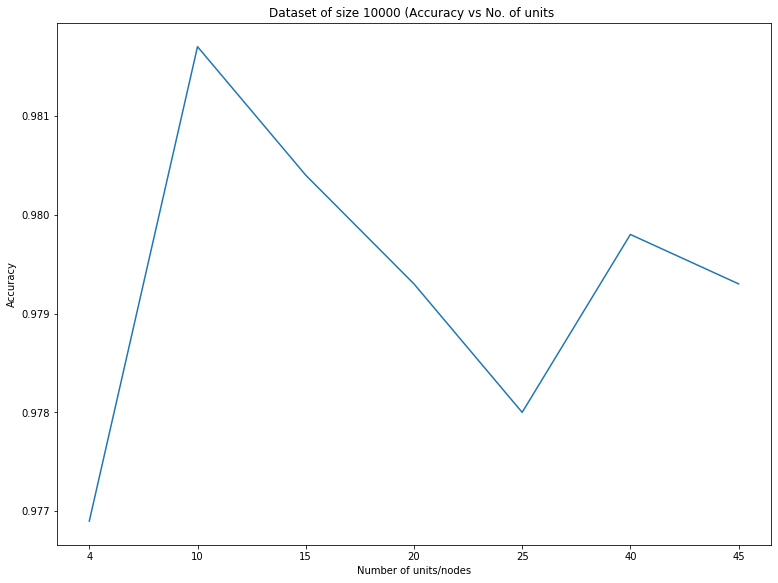

In [0]:
print("Best accuracy: %f using nodes= %s" % (result.best_score_, result.best_params_))
mean=result.cv_results_['mean_test_score']
acuuracy_plot(10000,i,mean)

In [0]:
final=classifier_complete(result.best_params_['i'],X,y,10000)

Epoch 1/1000
10000/10000 [==============================] - 0s 11us/step - loss: 2.6788 - acc: 0.1116
Epoch 2/1000
10000/10000 [==============================] - 0s 1us/step - loss: 2.4703 - acc: 0.1225
Epoch 3/1000
10000/10000 [==============================] - 0s 1us/step - loss: 2.2794 - acc: 0.1327
Epoch 4/1000
10000/10000 [==============================] - 0s 1us/step - loss: 2.1056 - acc: 0.1417
Epoch 5/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.9485 - acc: 0.1457
Epoch 6/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.8079 - acc: 0.1489
Epoch 7/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.6833 - acc: 0.1514
Epoch 8/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.5743 - acc: 0.1535
Epoch 9/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.4798 - acc: 0.1554
Epoch 10/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.3986 - 

In [0]:
print("The error rate for NN with 10000 datapoints is {0:.2f}".format(1-(final.predict_classes(X)==Y).mean()))
print("The accuracy for NN with 10000 datapoints is {}".format( (final.predict_classes(X)==Y).mean())  )

The error rate for NN with 10000 datapoints is 0.03
The accuracy for NN with 10000 datapoints is 0.9687


In [0]:
pred=final.predict_classes(test_x)
print("The error rate for NN for test case is {0:.2f}".format(1-(pred==test_y).mean()))
print("The accuracy for NN for test case is {}".format( (pred==test_y).mean())  )

The error rate for NN for test case is 0.43
The accuracy for NN for test case is 0.5702


#### 1000 data points

In [0]:
X,y,Y=get_data(1000)
estimator = KerasClassifier(build_fn=classifier, epochs=10, batch_size=4, verbose=0)
i=[4,8,12,16,24,28,32,36]
param_grid = dict(i=i)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=10,n_jobs=-1)
result = grid.fit(X, y)


Best accuracy: 0.972000 using nodes= {'i': 28}


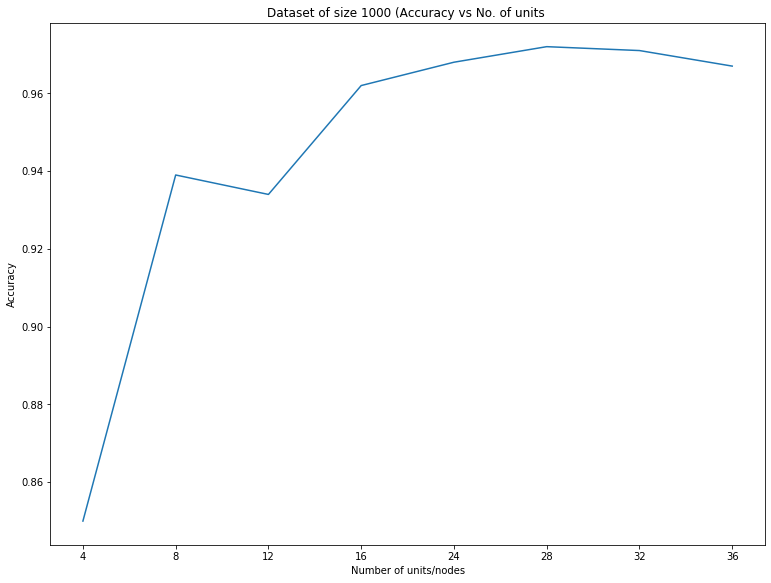

In [0]:
print("Best accuracy: %f using nodes= %s" % (result.best_score_, result.best_params_))
mean=result.cv_results_['mean_test_score']
acuuracy_plot(1000,i,mean)

In [0]:
final=classifier_complete(12,X,y,1000)

Epoch 1/1000
1000/1000 [==============================] - 0s 117us/step - loss: 2.2292 - acc: 0.4030
Epoch 2/1000
1000/1000 [==============================] - 0s 4us/step - loss: 2.1713 - acc: 0.4190
Epoch 3/1000
1000/1000 [==============================] - 0s 4us/step - loss: 2.1160 - acc: 0.4390
Epoch 4/1000
1000/1000 [==============================] - 0s 4us/step - loss: 2.0631 - acc: 0.4560
Epoch 5/1000
1000/1000 [==============================] - 0s 3us/step - loss: 2.0126 - acc: 0.4600
Epoch 6/1000
1000/1000 [==============================] - 0s 3us/step - loss: 1.9643 - acc: 0.4720
Epoch 7/1000
1000/1000 [==============================] - 0s 3us/step - loss: 1.9181 - acc: 0.4840
Epoch 8/1000
1000/1000 [==============================] - 0s 3us/step - loss: 1.8739 - acc: 0.4890
Epoch 9/1000
1000/1000 [==============================] - 0s 3us/step - loss: 1.8315 - acc: 0.4970
Epoch 10/1000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7910 - acc: 0.5060
Epoch 1

In [0]:
print("The error rate for NN with 1000 datapoints is {0:.2f}".format(1-(final.predict_classes(X)==Y).mean()))
print("The accuracy for NN with 1000 datapoints is {}".format( (final.predict_classes(X)==Y).mean())  )

The error rate for NN with 1000 datapoints is 0.03
The accuracy for NN with 1000 datapoints is 0.972


In [0]:
pred=final.predict_classes(test_x)
print("The error rate for NN for test case is {0:.2f}".format(1-(pred==test_y).mean()))
print("The accuracy for NN for test case is {}".format( (pred==test_y).mean())  )

The error rate for NN for test case is 0.53
The accuracy for NN for test case is 0.4742


In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv,pinv
from numpy.linalg import det
from numpy.linalg import norm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import empirical_covariance as ecov
from mpl_toolkits import mplot3d
from sklearn.datasets import make_spd_matrix # crating positive semidefinite matrix
from numpy import linalg as LA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline
np.random.seed(123)
plt.rcParams["figure.figsize"] = 12.8, 9.6
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from keras.utils import np_utils

In [0]:
Ntrain = 1000; 
Ntest = 10000; 
alpha = [0.33,0.34,0.33]; # must add to 1.0
mean1 = [-18, -8]
mean2 = [0, 0]
mean3 = [18, 8]
eig_val = np.array([[3.2**2, 0], [0, 0.6**2]])
eig_vec1 = np.array([[1, -1], [1, 1]])/np.sqrt(2)
eig_vec2 = np.array([[1, 0], [0, 1]])
eig_vec3 = np.array([[1, -1], [1, 1]])/np.sqrt(2)
cov1 = (eig_vec1@(eig_val@eig_vec1.T))
cov2 = (eig_vec2@(eig_val@eig_vec2.T))
cov3 = (eig_vec3@(eig_val@eig_vec3.T))


In [0]:
def gen_X(alpha,count):
  cf=np.cumsum(np.array(alpha))
  t=np.random.rand(count)
  ind1=np.where(t<cf[0])
  ind2=np.where((t>=cf[0]) & (t<cf[1]))
  ind3=np.where(t>=cf[1])
  n1=len(ind1[0])
  n2=len(ind2[0])
  n3=len(ind3[0])
  dataset=np.vstack(( np.random.multivariate_normal(mean1,cov1 ,n1), np.random.multivariate_normal(mean2,cov2 ,n2), np.random.multivariate_normal(mean3,cov3 ,n3) ))
  return(dataset)


In [0]:
train=gen_X(alpha,1000)
test=gen_X(alpha,10000)

Text(0.5, 1.0, 'PLotting training data')

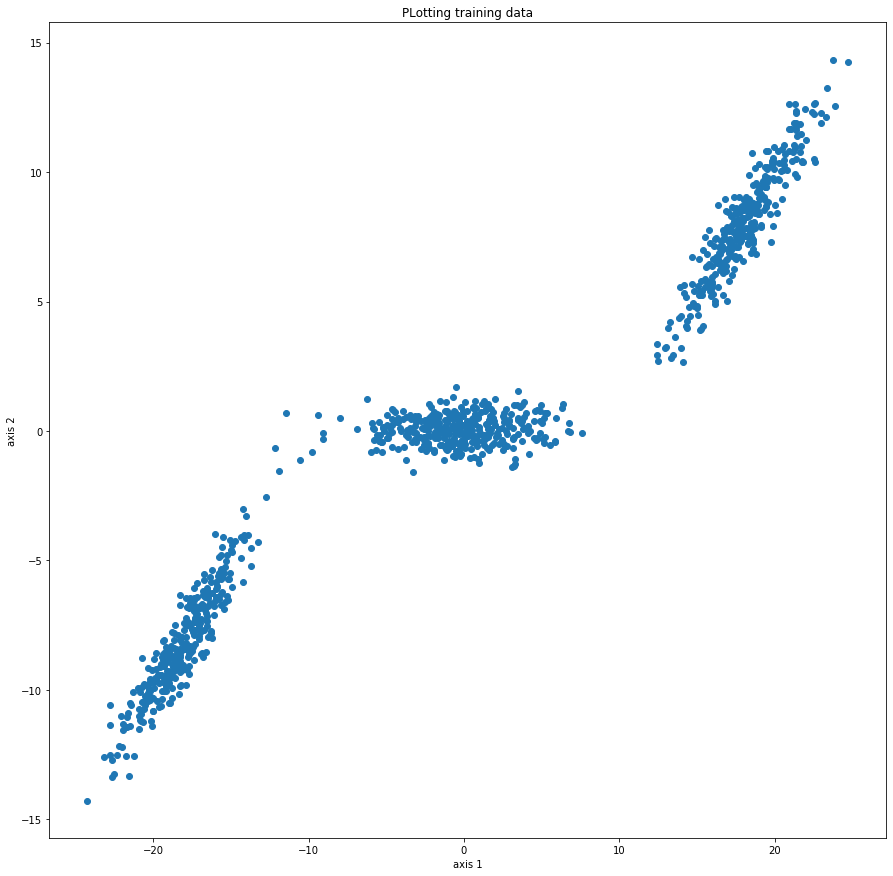

In [0]:
plt.figure(figsize=(15,15))
plt.scatter(train[:,0],train[:,1])
plt.xlabel("axis 1")
plt.ylabel("axis 2")
plt.title("PLotting training data")

Text(0.5, 1.0, 'PLotting test data')

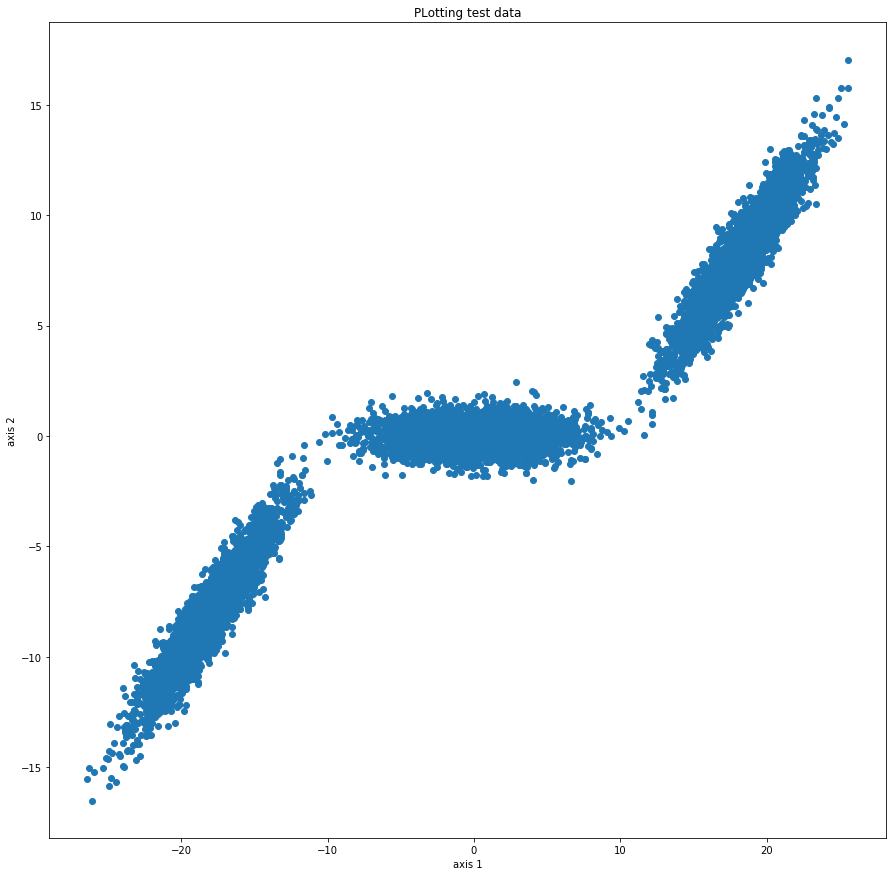

In [0]:
plt.figure(figsize=(15,15))
plt.scatter(test[:,0],test[:,1])
plt.xlabel("axis 1")
plt.ylabel("axis 2")
plt.title("PLotting test data")

In [0]:
def k_fold(dataset, targets, activations, hidd_layer_param_list, epochs=50):
    kf = KFold(n_splits=10)
    param = []
    for activation in activations:
        typeo=[]      
        for param in hidd_layer_param_list:
            fold_loss = []
            for train_index, test_index in kf.split(dataset):

                # print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = dataset[train_index], dataset[test_index]
                y_train, y_test = targets[train_index], targets[test_index]

                # Training the Multilayer Perceptron
                model = Sequential()
                model.add(Dense(param, input_dim=1, activation=activation))
                model.add(Dense(1))
                model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mean_squared_error'])
                model.fit(X_train, y_train, epochs=epochs, verbose=0, batch_size=1000)

                #Validating the weights on the test set by calculating Mean Squared Error
                scores = model.evaluate(X_test, y_test)
#                 print(scores)

                fold_loss.append(scores[1])
              
            typeo.append(sum(fold_loss)/10)
        param.append(typeo)
    
    return param

In [0]:
activations = ['softplus', 'sigmoid']
hidd_layer_param_list = [4,8,10,15,20,25,30,35,40]

In [0]:
 param_loss = k_fold(train[:, 0], train[:, 1], activations, hidd_layer_param_list)

100/100 [==============================] - 9s 90ms/step


In [0]:
  plt.plot(range(len(hidd_layer_param_list)),param_loss[0],label='softplus')
  plt.plot(range(len(hidd_layer_param_list)),param_loss[1],label='sigmoid')
  plt.xticks(range(len(hidd_layer_param_list)),hidd_layer_param_list)
  plt.ylabel("Mean squared Error")
  plt.xlabel("Number of units/nodes")
  plt.title("Dataset of size {} (Accuracy vs No. of units ".format(1000))
  plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
model = Sequential()
model.add(Dense(30, input_dim=1, activation='softplus'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mean_squared_error'])
model.fit(train[:,0], train[:,1], epochs=1000, verbose=0, batch_size=1000)

In [0]:
pred=model.predict(test[:,0])

In [0]:
plt.plot(test[:,0],test[:,1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pred

array([[-7.4262958],
       [-6.301157 ],
       [-6.937216 ],
       ...,
       [11.234966 ],
       [ 8.952578 ],
       [ 7.725623 ]], dtype=float32)

In [0]:
with open('/content/drive/My Drive/prediction_2.txt', 'w') as filehandle:
    for listitem in pred:
        filehandle.write('%s\n' % listitem)

In [0]:
with open('/content/drive/My Drive/test.txt', 'w') as filehandle:
    for listitem in test:
        filehandle.write('%s\n' % listitem)

In [0]:
with open('/content/drive/My Drive/param_loss.txt', 'w') as filehandle:
    for listitem in param_loss:
        filehandle.write('%s\n' % listitem)

In [0]:
param_loss=np.load('/content/drive/My Drive/param_loss.txt.npy')

In [0]:
test=np.load('/content/drive/My Drive/test.txt.npy')
pred=np.load('/content/drive/My Drive/prediction_2.txt.npy')

In [0]:
param_loss
hidd_layer_param_list = [4,8,10,15,20,25,30,35,40]

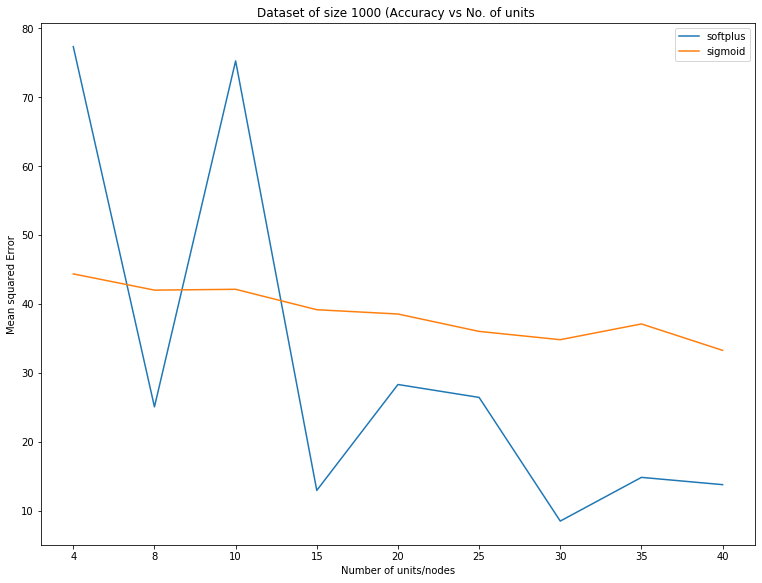

In [0]:
  plt.plot(range(len(hidd_layer_param_list)),param_loss[0],label='softplus')
  plt.plot(range(len(hidd_layer_param_list)),param_loss[1],label='sigmoid')
  plt.xticks(range(len(hidd_layer_param_list)),hidd_layer_param_list)
  plt.ylabel("Mean squared Error")
  plt.xlabel("Number of units/nodes")
  plt.title("Dataset of size {} (Accuracy vs No. of units ".format(1000))
  plt.legend()
  plt.show()

Text(0.5, 1.0, 'Real values vs Predicted values on test set')

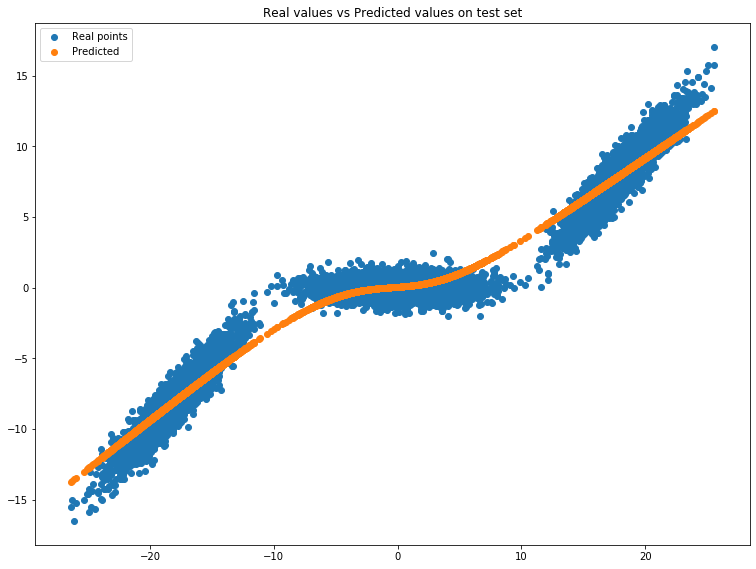

In [0]:
plt.scatter(test[:,0],test[:,1],label="Real points")
plt.scatter(test[:,0],pred,label="Predicted")
plt.legend()
plt.title("Real values vs Predicted values on test set")